In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob

In [2]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_processed.nc")
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 73, bnds: 2, s_rho: 31, s_w: 32, tracer: 2,
                      boundary: 4, Nuser: 1, eta_rho: 600, xi_rho: 800,
                      xi_u: 799, eta_v: 599)
Coordinates:
  * ocean_time       (ocean_time) datetime64[ns] 2025-12-30 ... 2026-12-25
  * s_rho            (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w              (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    lat_rho          (eta_rho, xi_rho) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0           (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: bnds, tracer, boundary, Nuser, eta_rho, xi_rho,
                                xi_u, eta_v
Data variables: (12/51)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    z_u              (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    z_v              (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dx               (eta_rho, xi_rho) float64 ...
    dy               (eta_rho, xi_rho) float64 ...
    dz               (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    dA               (eta_rho, xi_rho) float64 ...
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [3]:
ds=ds.isel(ocean_time=slice(0,73))

In [3]:
ds['hc']=20
def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])



    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

        # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

ds = processROMSGrid(ds)

grid = makeROMSGridObject(ds)

In [4]:
ds=ds.set_coords(("lon_rho","lat_rho"))
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 73, bnds: 2, s_rho: 31, s_w: 32, tracer: 2,
                      boundary: 4, Nuser: 1, eta_rho: 600, xi_rho: 800,
                      xi_u: 799, eta_v: 599)
Coordinates:
  * ocean_time       (ocean_time) datetime64[ns] 2025-12-30 ... 2026-12-25
  * s_rho            (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w              (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    lat_rho          (eta_rho, xi_rho) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 ... -0.00...
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 ... -0....
    z_rho0           (eta_rho, xi_rho, s_rho) float64 0.0 0.0 ... -0.2858
Dimensions without coordinates: bnds, tracer, boundary, Nuser, eta_rho, xi_rho,
                                xi_u, eta_v
Data variables: (12/73)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    dz_w             (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 ... 0.2681
    dz_u             (ocean_time, s_rho, eta_rho, xi_u) float64 0.0 ... 0.5359
    dz_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 0.0 0.0 ... 0.2689
    dz_v             (ocean_time, s_rho, eta_v, xi_rho) float64 0.0 ... 0.5413
    dz_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 0.0 0.0 ... 0.2712
    dA               (eta_rho, xi_rho) float64 1.071e+06 1.071e+06 ... 1.129e+06
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

Surface Velocities

In [3]:
# declare this velocity magnitude field that we use for colouring our streamlines
#del snap_shot

snap_shot = ds#.sel(ocean_time=ds.ocean_time.dt.month.isin([12, 1,2]))
snap_shot["speed"] = np.sqrt(snap_shot.u_eastward.isel(s_rho=-1).mean(dim="ocean_time").squeeze()**2+snap_shot.v_northward.isel(s_rho=-1).mean(dim="ocean_time").squeeze()**2)
snap_shot['Umean']=snap_shot.u_eastward.isel(s_rho=-1).mean(dim="ocean_time")
snap_shot['Vmean']=snap_shot.v_northward.isel(s_rho=-1).mean(dim="ocean_time")


In [15]:
del snap_shot

snap_shot = ds.isel(ocean_time=49)
snap_shot["speed"] = np.sqrt(snap_shot.u_eastward.isel(s_rho=-1).squeeze()**2+snap_shot.v_northward.isel(s_rho=-1).squeeze()**2)
snap_shot['Umean']=snap_shot.u_eastward.isel(s_rho=-1)
snap_shot['Vmean']=snap_shot.v_northward.isel(s_rho=-1)

In [5]:
snap_shot["speedSD"] = np.sqrt(snap_shot.u_eastward.isel(s_rho=-1).squeeze()**2+snap_shot.v_northward.isel(s_rho=-1).squeeze()**2).std(dim="ocean_time")
snap_shot['UmeanSD']=snap_shot.u_eastward.isel(s_rho=-1).std(dim="ocean_time")
snap_shot['VmeanSD']=snap_shot.v_northward.isel(s_rho=-1).std(dim="ocean_time")

Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

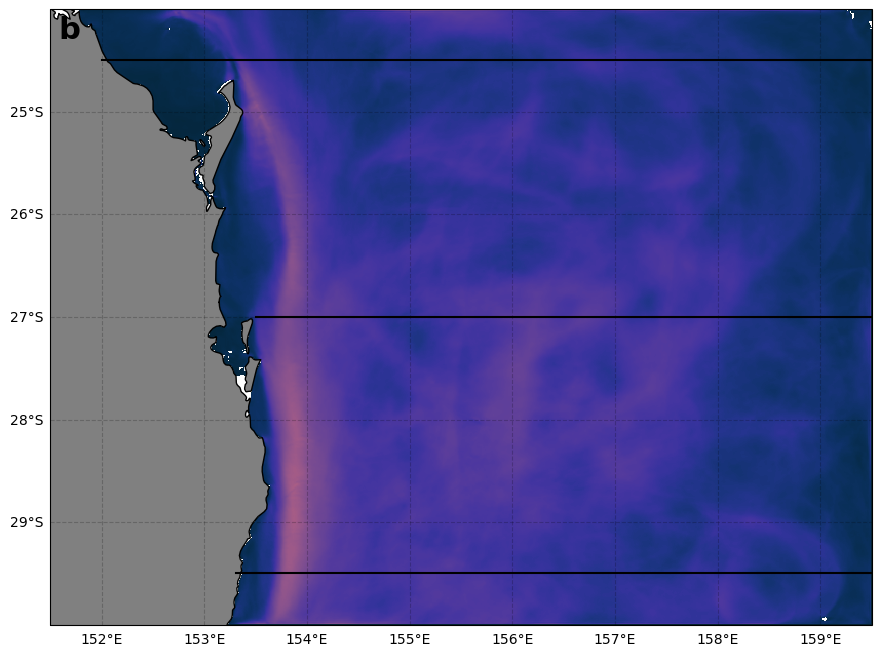

In [9]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 159.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ax.pcolormesh(snap_shot.lon_rho,snap_shot.lat_rho,snap_shot.speedSD,cmap='cmo.thermal')
im.set_clim(0,1)

plt.plot(ds.lon_rho.isel(eta_rho=550,xi_rho=slice(50,800)),
         ds.lat_rho.isel(eta_rho=550,xi_rho=slice(50,800)),
         color='black')

plt.plot(ds.lon_rho.isel(eta_rho=300,xi_rho=slice(200,800)),
         ds.lat_rho.isel(eta_rho=300,xi_rho=slice(200,800)),
         color='black')

plt.plot(ds.lon_rho.isel(eta_rho=50,xi_rho=slice(180,800)),
         ds.lat_rho.isel(eta_rho=50,xi_rho=slice(180,800)),
         color='black')

gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True

#cbar = fig.colorbar(im)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_title('')

#cbar.set_label('Speed (m/s)')
ax.set_title('') 

Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

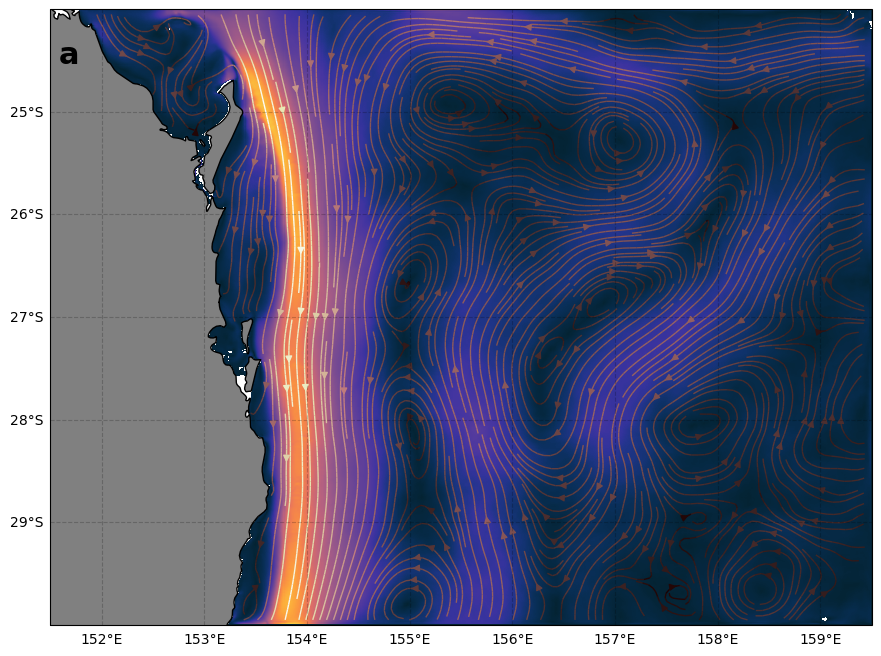

In [8]:
# a full example of streamplot over the top of other data

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None

# other streamplot options:
str_kwargs = {"color":snap_shot.speed.values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink",
             "transform":ccrs.PlateCarree()}

pcol_kwargs = {"cmap":"cmo.thermal"}


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 159.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ax.pcolormesh(snap_shot.lon_rho,snap_shot.lat_rho,snap_shot.speed,cmap='cmo.thermal')
im.set_clim(0,1)
st = ax.streamplot(snap_shot.lon_rho, snap_shot.lat_rho, snap_shot.Umean.values, snap_shot.Vmean.values, **str_kwargs)
gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True


ax.text(0.01, 0.95, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax.set_title('') 

Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

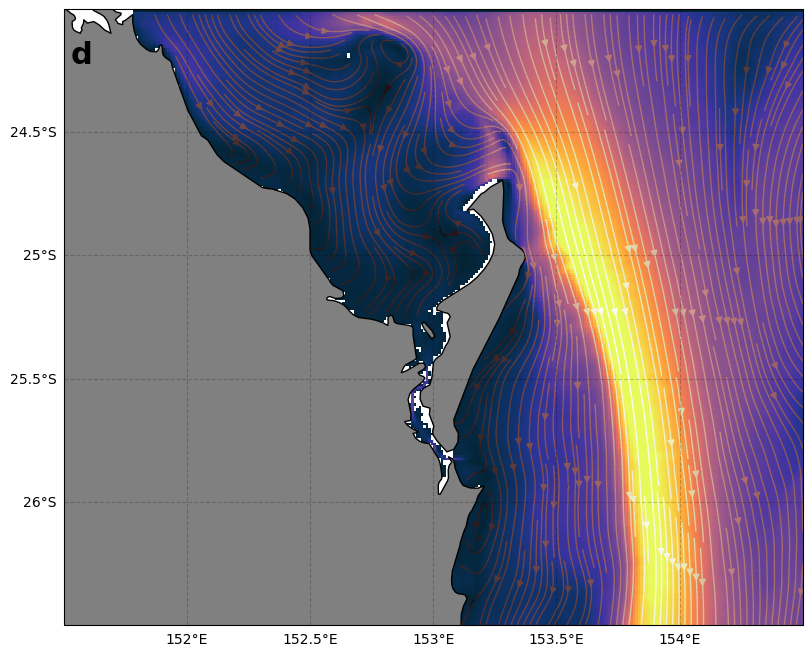

In [14]:

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None

# other streamplot options:
str_kwargs = {"color":snap_shot.speed.values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink",
             "transform":ccrs.PlateCarree()}

pcol_kwargs = {"cmap":"cmo.thermal"}


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 154.5, -26.5, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ax.pcolormesh(snap_shot.lon_rho,snap_shot.lat_rho,snap_shot.speed,cmap='cmo.thermal')
im.set_clim(0,1)
st = ax.streamplot(snap_shot.lon_rho, snap_shot.lat_rho, snap_shot.Umean.values, snap_shot.Vmean.values, **str_kwargs)
gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True

ax.text(0.01, 0.95, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax.set_title('') 

Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

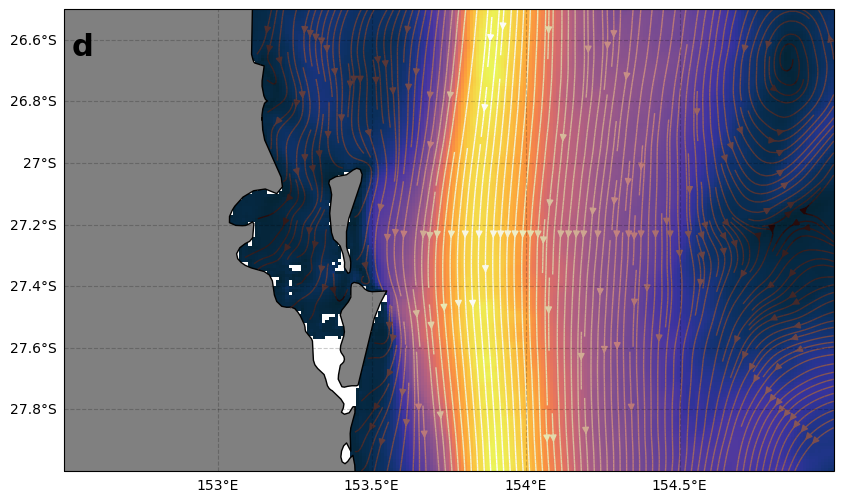

In [15]:

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,6])
ax = None

# other streamplot options:
str_kwargs = {"color":snap_shot.speed.values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink",
             "transform":ccrs.PlateCarree()}

pcol_kwargs = {"cmap":"cmo.thermal"}


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([152.5, 155, -28, -26.5])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ax.pcolormesh(snap_shot.lon_rho,snap_shot.lat_rho,snap_shot.speed,cmap='cmo.thermal')
im.set_clim(0,1)
st = ax.streamplot(snap_shot.lon_rho, snap_shot.lat_rho, snap_shot.Umean.values, snap_shot.Vmean.values, **str_kwargs)
gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True

ax.text(0.01, 0.95, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax.set_title('') 

Temperature and other

Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

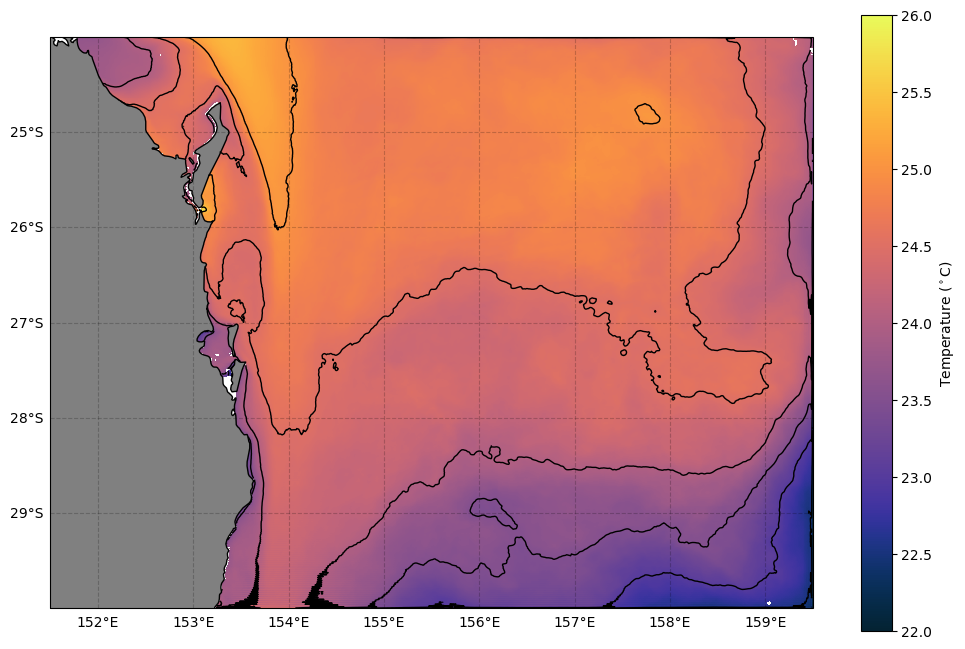

In [11]:
# a full example of streamplot over the top of other data

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 159.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).mean(dim="ocean_time"),cmap='cmo.thermal')
im.set_clim(22,26)
ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).mean(dim='ocean_time'),colors='k',linewidths=1,levels=np.arange(22,26,.5))  


gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True

cbar = fig.colorbar(im)
ax.text(0.01, 0.99, '', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_title('')

cbar.set_label('Temperature ($^\circ$C)')
ax.set_title('') 

Cross-sections

Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

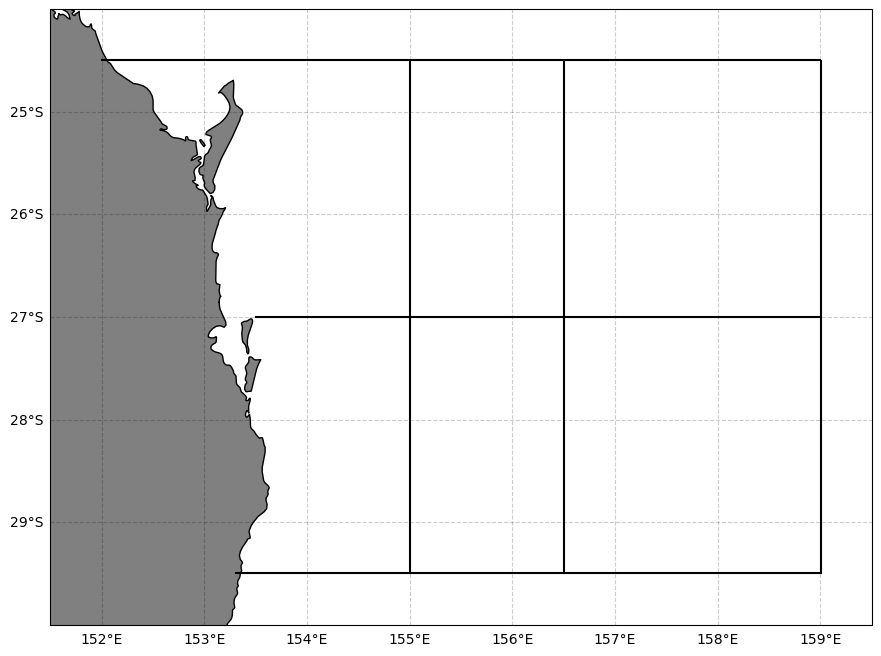

In [3]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 159.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')

plt.plot(ds.lon_rho.isel(eta_rho=550,xi_rho=slice(50,750)),
         ds.lat_rho.isel(eta_rho=550,xi_rho=slice(50,750)),
         color='black')

plt.plot(ds.lon_rho.isel(eta_rho=300,xi_rho=slice(200,750)),
         ds.lat_rho.isel(eta_rho=300,xi_rho=slice(200,750)),
         color='black')

plt.plot(ds.lon_rho.isel(eta_rho=50,xi_rho=slice(180,750)),
         ds.lat_rho.isel(eta_rho=50,xi_rho=slice(180,750)),
         color='black')

plt.plot(ds.lon_rho.isel(eta_rho=slice(50,550),xi_rho=350),
         ds.lat_rho.isel(eta_rho=slice(50,550),xi_rho=350),
         color='black')

plt.plot(ds.lon_rho.isel(eta_rho=slice(50,550),xi_rho=500),
         ds.lat_rho.isel(eta_rho=slice(50,550),xi_rho=500),
         color='black')

plt.plot(ds.lon_rho.isel(eta_rho=slice(50,550),xi_rho=750),
         ds.lat_rho.isel(eta_rho=slice(50,550),xi_rho=750),
         color='black')

gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
#axis labels
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True


ax.text(0.01, 0.99, ' ', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_title('')


ax.set_title('')

/tmp/ipykernel_3426264/1092104598.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(ds.lon_rho.isel(eta_rho=550,xi_rho=slice(50,750)),
/tmp/ipykernel_3426264/1092104598.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(ds.lon_rho.isel(eta_rho=300,xi_rho=slice(200,750)),
/tmp/ipykernel_3426264/1092104598.py:38: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edge

<Figure size 640x480 with 0 Axes>

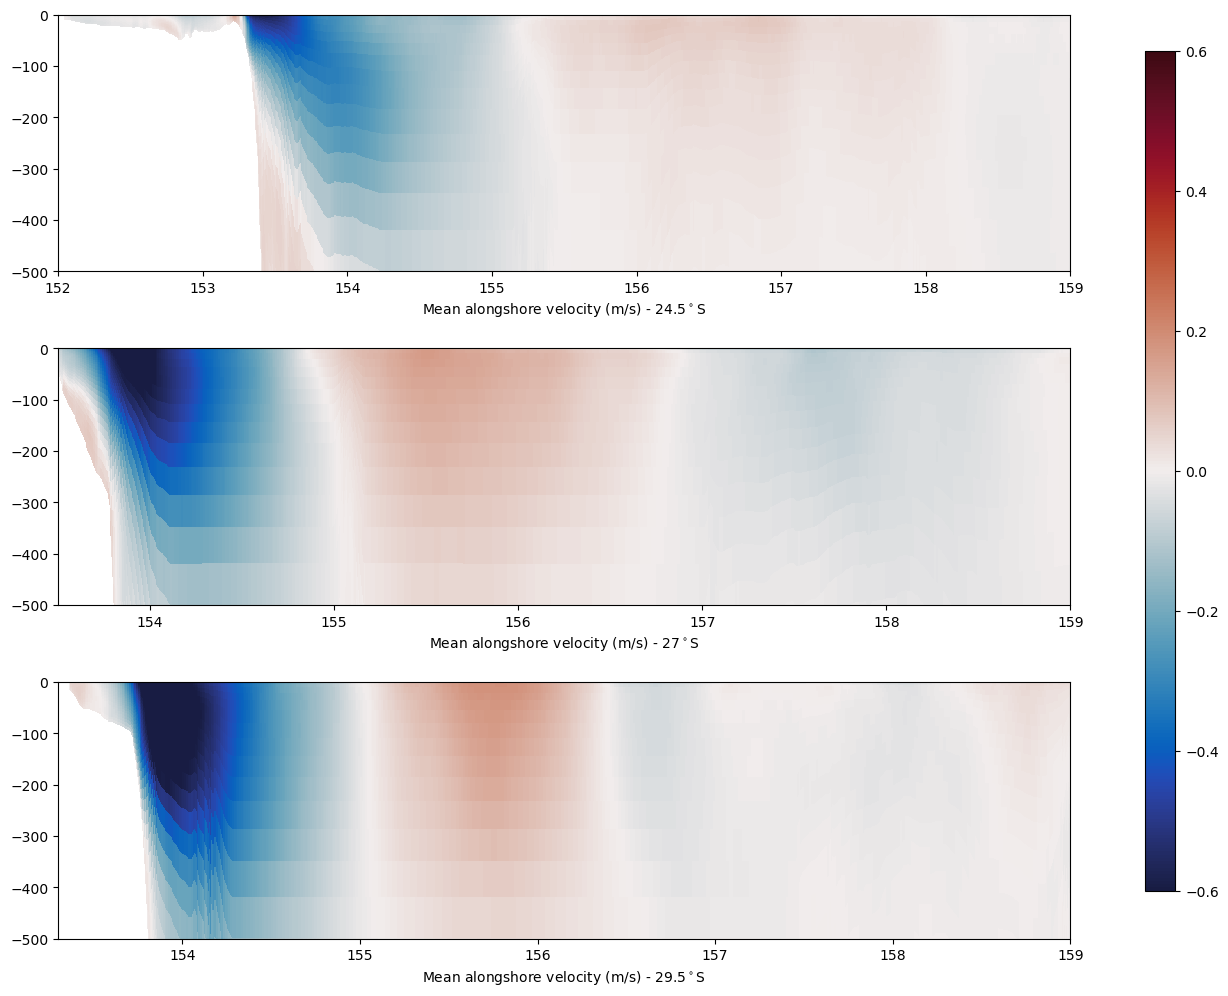

In [11]:
gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])#what is this?
ax = None

ax = fig.add_subplot(gs[0,0])
im = ax.pcolormesh(ds.lon_rho.isel(eta_rho=550,xi_rho=slice(50,750)),
                   ds.z_rho.isel(eta_rho=550,xi_rho=slice(50,750)).mean(dim="ocean_time"),
                   ds.v_northward.isel(eta_rho=550,xi_rho=slice(50,750)).mean(dim="ocean_time"),
                   cmap='cmo.balance')

im.set_clim(-0.6,0.6)
plt.ylim(-500,0)




plt.xlabel('Mean alongshore velocity (m/s) - 24.5$^\circ$S')
ax.set_title('')

ax = fig.add_subplot(gs[1,0])
im = ax.pcolormesh(ds.lon_rho.isel(eta_rho=300,xi_rho=slice(200,750)),
                   ds.z_rho.isel(eta_rho=300,xi_rho=slice(200,750)).mean(dim="ocean_time"),
                   ds.v_northward.isel(eta_rho=300,xi_rho=slice(200,750)).mean(dim="ocean_time"),
                   cmap='cmo.balance')
im.set_clim(-0.6,0.6)
plt.ylim(-500,0)





plt.xlabel('Mean alongshore velocity (m/s) - 27$^\circ$S')
ax.set_title('')

ax = fig.add_subplot(gs[2,0])
im = ax.pcolormesh(ds.lon_rho.isel(eta_rho=50,xi_rho=slice(180,750)),
                   ds.z_rho.isel(eta_rho=50,xi_rho=slice(180,750)).mean(dim="ocean_time"),
                   ds.v_northward.isel(eta_rho=50,xi_rho=slice(180,750)).mean(dim="ocean_time"),
                   cmap='cmo.balance')
#ax.contour(ds.lon_rho,ds.z_rho,ds.v_north.isel(eta_rho=etaTransect),np.arange(-1,0,0.05), colors='k', linewidths=1)
im.set_clim(-0.6,0.6)
plt.ylim(-500,0)



plt.xlabel('Mean alongshore velocity (m/s) - 29.5$^\circ$S')
ax.set_title('')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


/tmp/ipykernel_3450582/409128042.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(ds.lat_rho.isel(eta_rho=slice(400,600),xi_rho=350),
/tmp/ipykernel_3450582/409128042.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(ds.lat_rho.isel(eta_rho=slice(400,600),xi_rho=500),
/tmp/ipykernel_3450582/409128042.py:46: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges 

<Figure size 640x480 with 0 Axes>

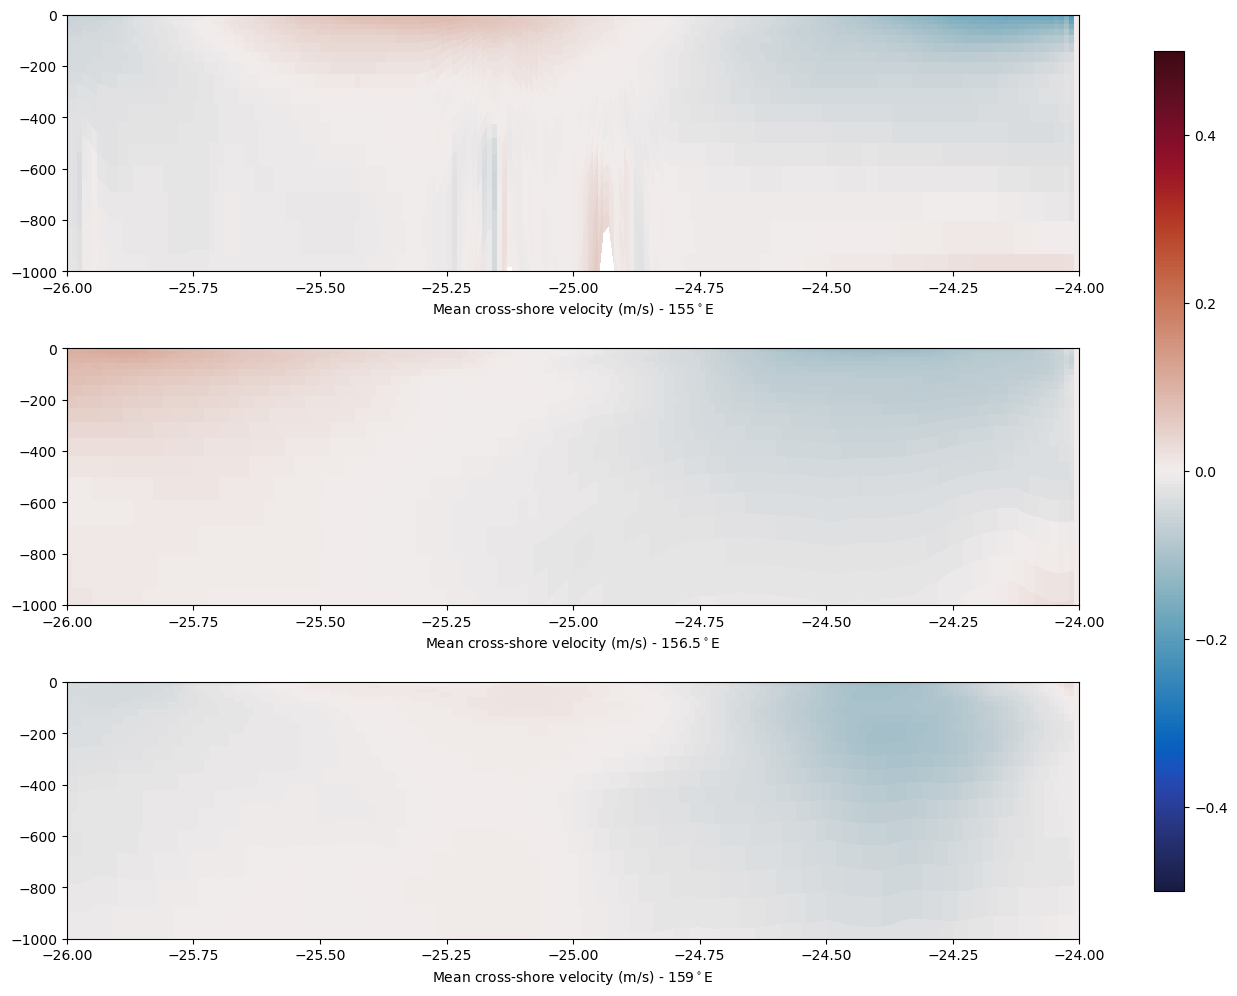

In [5]:
gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])#what is this?
ax = None

ax = fig.add_subplot(gs[0,0])
im = ax.pcolormesh(ds.lat_rho.isel(eta_rho=slice(400,600),xi_rho=350),
                   ds.z_rho.isel(eta_rho=slice(400,600),xi_rho=350).mean(dim="ocean_time"),
                   ds.u_eastward.isel(eta_rho=slice(400,600),xi_rho=350).mean(dim="ocean_time"),
                   cmap='cmo.balance')
im.set_clim(-0.5,0.5)
plt.ylim(-1000,0)

#axis labels
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True



plt.xlabel('Mean cross-shore velocity (m/s) - 155$^\circ$E')
ax.set_title('')

ax = fig.add_subplot(gs[1,0])
im = ax.pcolormesh(ds.lat_rho.isel(eta_rho=slice(400,600),xi_rho=500),
                   ds.z_rho.isel(eta_rho=slice(400,600),xi_rho=500).mean(dim="ocean_time"),
                   ds.u_eastward.isel(eta_rho=slice(400,600),xi_rho=500).mean(dim="ocean_time"),
                   cmap='cmo.balance')
im.set_clim(-0.5,0.5)
plt.ylim(-1000,0)

#axis labels
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True



plt.xlabel('Mean cross-shore velocity (m/s) - 156.5$^\circ$E')
ax.set_title('')

ax = fig.add_subplot(gs[2,0])
im = ax.pcolormesh(ds.lat_rho.isel(eta_rho=slice(400,600),xi_rho=750),
                   ds.z_rho.isel(eta_rho=slice(400,600),xi_rho=750).mean(dim="ocean_time"),
                   ds.u_eastward.isel(eta_rho=slice(400,600),xi_rho=750).mean(dim="ocean_time"),
                   cmap='cmo.balance')
im.set_clim(-0.5,0.5)
plt.ylim(-1000,0)

#axis labels
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True

plt.xlabel('Mean cross-shore velocity (m/s) - 159$^\circ$E')
ax.set_title('')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

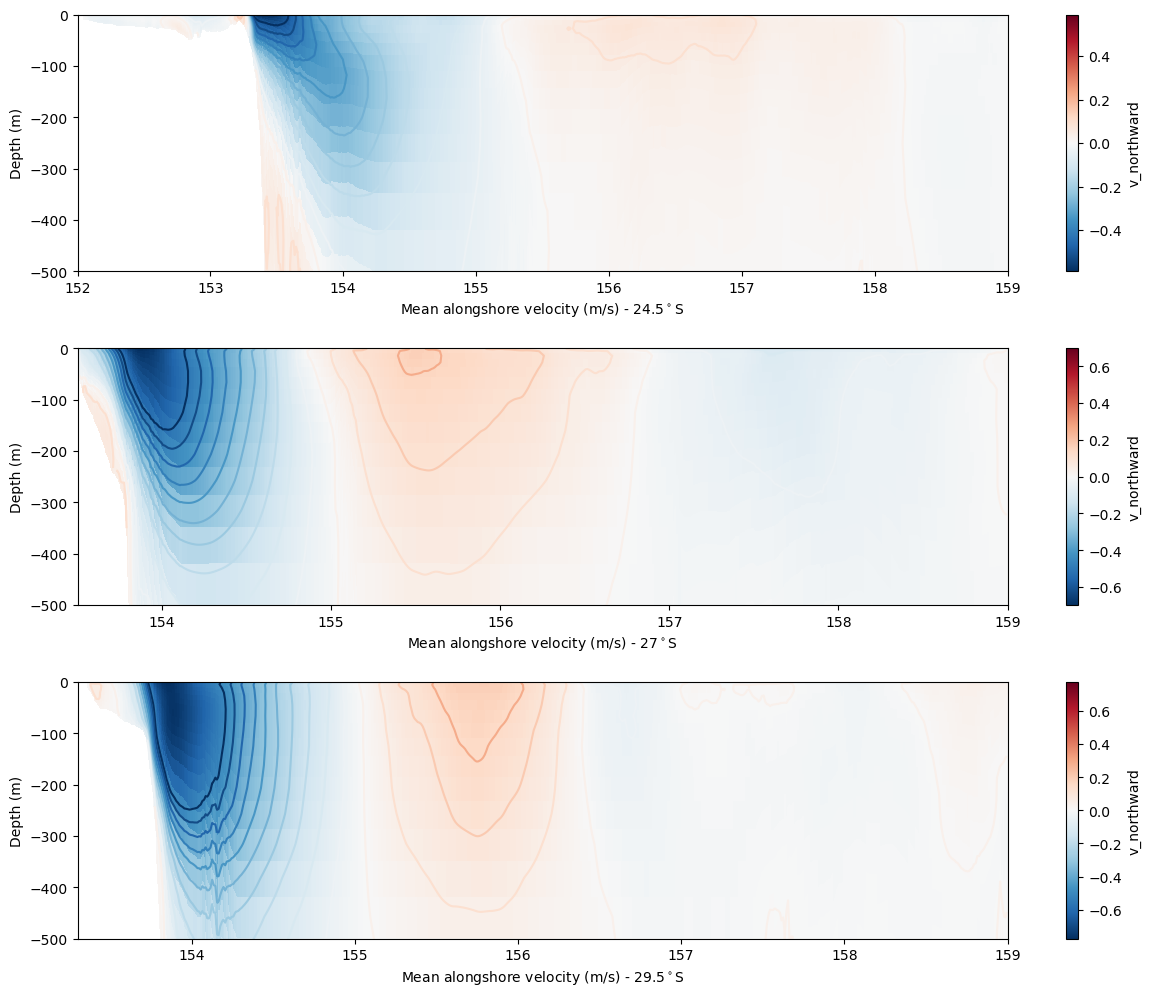

In [22]:
section1=ds.isel(eta_rho=550,xi_rho=slice(50,750))
section2=ds.isel(eta_rho=300,xi_rho=slice(200,750))
section3=ds.isel(eta_rho=50,xi_rho=slice(180,750))


gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])#what is this?
ax = None

ax = fig.add_subplot(gs[0,0])
section1.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section1.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-500,0)
plt.xlabel('Mean alongshore velocity (m/s) - 24.5$^\circ$S')
plt.ylabel('Depth (m)')

ax = fig.add_subplot(gs[1,0])
section2.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section2.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-500,0)
plt.xlabel('Mean alongshore velocity (m/s) - 27$^\circ$S')
plt.ylabel('Depth (m)')

ax = fig.add_subplot(gs[2,0])
section3.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section3.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-500,0)
plt.xlabel('Mean alongshore velocity (m/s) - 29.5$^\circ$S')
plt.ylabel('Depth (m)')

ax.set_title('')

<Figure size 640x480 with 0 Axes>

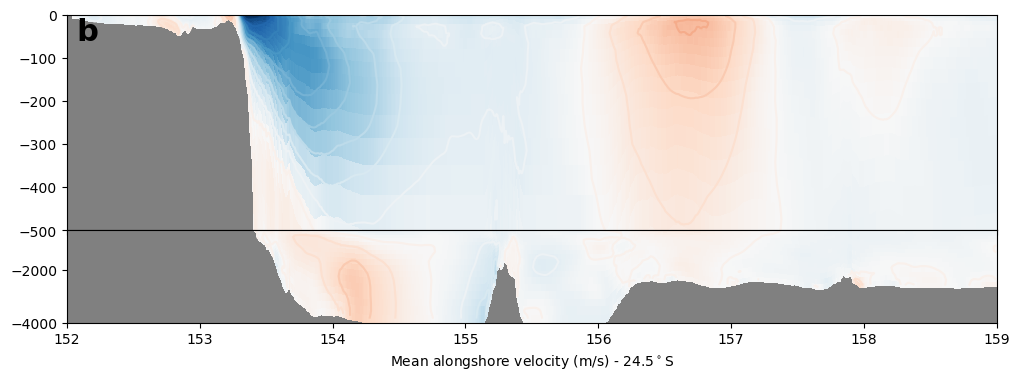

In [20]:

section1=ds.isel(eta_rho=550,xi_rho=slice(50,750)).sel(ocean_time=ds.ocean_time.dt.month.isin([3, 4,5]))


gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.00,height_ratios=[.7,.3])
plt.cla()
plt.clf()
fig245 = plt.figure(figsize=[15,4])#what is this?
ax = None

ax = fig245.add_subplot(gs[0,0])
ax.set_facecolor('gray')
im=section1.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section1.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-500,0)
plt.xlim(152,159)
plt.ylabel('')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
fig245.delaxes(fig245.axes[1])

ax.set_xticklabels([])
ax = fig245.add_subplot(gs[1,0])
ax.set_facecolor('gray')
im=section1.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section1.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-4000,-500)
plt.xlim(152,159)
plt.xlabel('Mean alongshore velocity (m/s) - 24.5$^\circ$S')
plt.ylabel('')

fig245.delaxes(fig245.axes[2])


<Figure size 640x480 with 0 Axes>

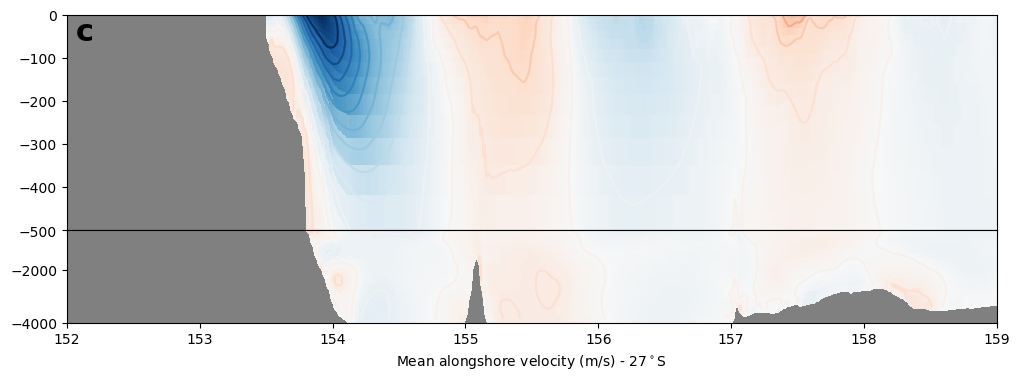

In [16]:

section2=ds.isel(eta_rho=300,xi_rho=slice(200,750)).sel(ocean_time=ds.ocean_time.dt.month.isin([6, 7,8]))


gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.00,height_ratios=[.7,.3])
plt.cla()
plt.clf()
fig27 = plt.figure(figsize=[15,4])#what is this?
ax = None

ax = fig27.add_subplot(gs[0,0])
ax.set_facecolor('gray')
im=section2.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section2.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-500,0)
plt.xlim(152,159)
plt.ylabel('')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
fig27.delaxes(fig27.axes[1])

ax.set_xticklabels([])
ax = fig27.add_subplot(gs[1,0])
ax.set_facecolor('gray')
im=section2.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section2.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-4000,-500)
plt.xlim(152,159)
plt.xlabel('Mean alongshore velocity (m/s) - 27$^\circ$S')
plt.ylabel('')

fig27.delaxes(fig27.axes[2])

<Figure size 640x480 with 0 Axes>

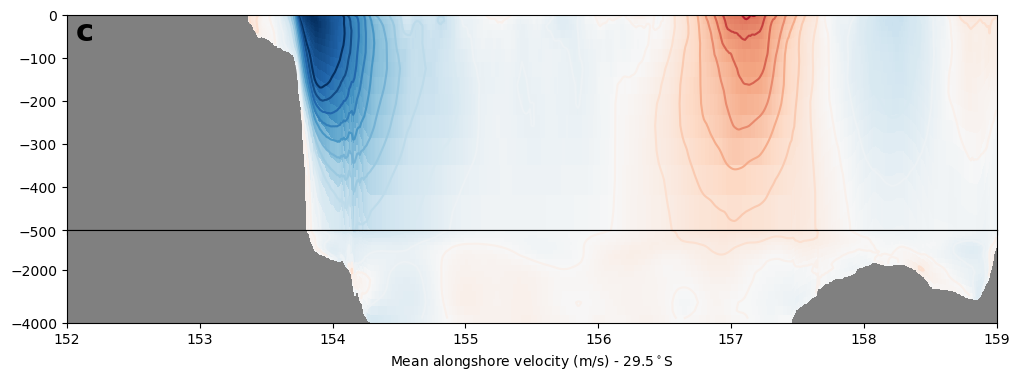

In [12]:
section3=ds.isel(eta_rho=50,xi_rho=slice(180,750)).sel(ocean_time=ds.ocean_time.dt.month.isin([6, 7,8]))

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.00,height_ratios=[.7,.3])
plt.cla()
plt.clf()
fig295 = plt.figure(figsize=[15,4])#what is this?
ax = None

ax = fig295.add_subplot(gs[0,0])
ax.set_facecolor('gray')
im=section3.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section3.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-500,0)
plt.xlim(152,159)
plt.ylabel('')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
fig295.delaxes(fig295.axes[1])

ax.set_xticklabels([])
ax = fig295.add_subplot(gs[1,0])
ax.set_facecolor('gray')
im=section3.v_northward.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section3.v_northward.mean(dim="ocean_time"),levels=np.arange(-0.5,0.5,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-4000,-500)
plt.xlim(152,159)
plt.xlabel('Mean alongshore velocity (m/s) - 29.5$^\circ$S')
plt.ylabel('')

fig295.delaxes(fig295.axes[2])


Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

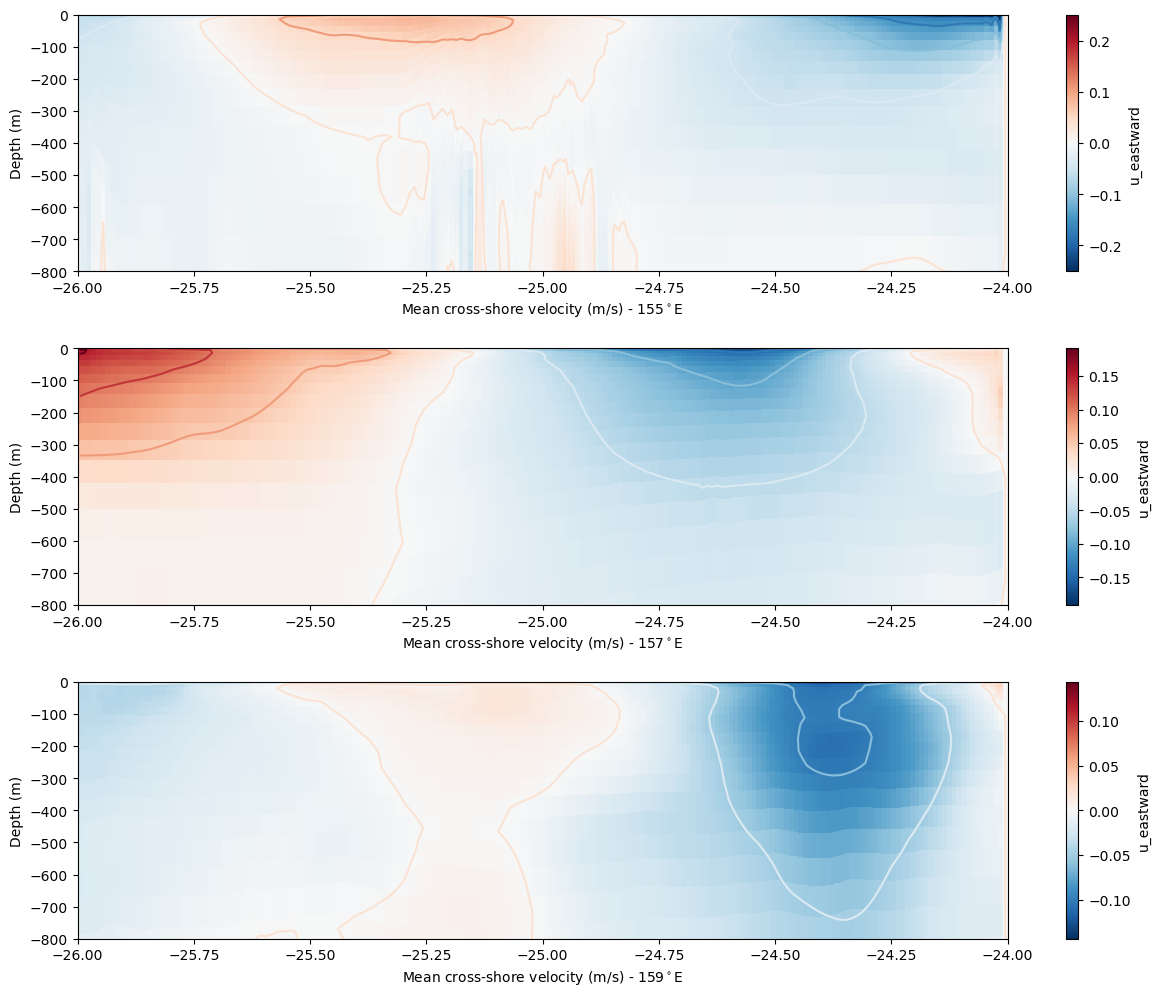

In [8]:
section1=ds.isel(eta_rho=slice(400,600),xi_rho=350)
section2=ds.isel(eta_rho=slice(400,600),xi_rho=550)
section3=ds.isel(eta_rho=slice(400,600),xi_rho=750)


gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])#what is this?
ax = None

ax = fig.add_subplot(gs[0,0])
section1.u_eastward.mean(dim="ocean_time").plot(x='lat_rho',y='z_rho0')
xr.plot.contour(section1.u_eastward.mean(dim="ocean_time"),levels=np.arange(-0.2,0.2,0.05),x="lat_rho",y="z_rho0")
plt.ylim(-800,0)
plt.xlabel('Mean cross-shore velocity (m/s) - 155$^\circ$E')
plt.ylabel('Depth (m)')

ax = fig.add_subplot(gs[1,0])
section2.u_eastward.mean(dim="ocean_time").plot(x='lat_rho',y='z_rho0')
xr.plot.contour(section2.u_eastward.mean(dim="ocean_time"),levels=np.arange(-0.2,0.2,0.05),x="lat_rho",y="z_rho0")
plt.ylim(-800,0)
plt.xlabel('Mean cross-shore velocity (m/s) - 157$^\circ$E')
plt.ylabel('Depth (m)')

ax = fig.add_subplot(gs[2,0])
section3.u_eastward.mean(dim="ocean_time").plot(x='lat_rho',y='z_rho0')
xr.plot.contour(section3.u_eastward.mean(dim="ocean_time"),levels=np.arange(-0.2,0.2,0.05),x="lat_rho",y="z_rho0")
plt.ylim(-800,0)
plt.xlabel('Mean cross-shore velocity (m/s) - 159$^\circ$E')
plt.ylabel('Depth (m)')

ax.set_title('')

<Figure size 640x480 with 0 Axes>

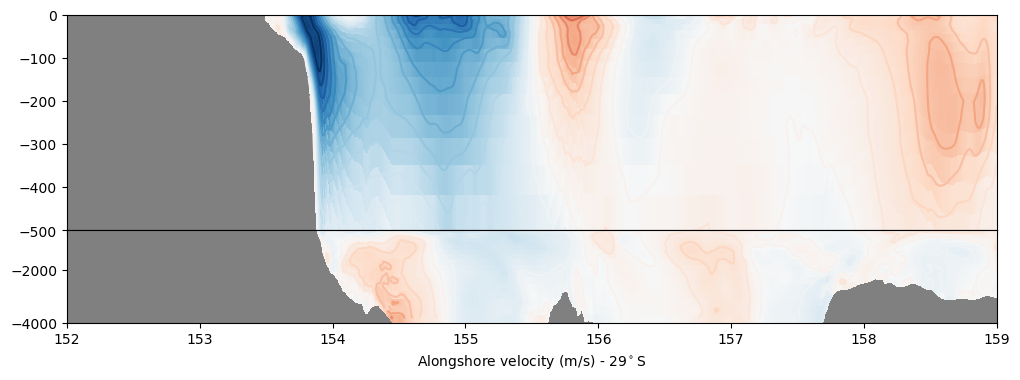

In [7]:
section3=ds.isel(eta_rho=100,xi_rho=slice(180,750))

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.00,height_ratios=[.7,.3])
plt.cla()
plt.clf()
fig295 = plt.figure(figsize=[15,4])#what is this?
ax = None

ax = fig295.add_subplot(gs[0,0])
ax.set_facecolor('gray')
im=section3.v_northward.isel(ocean_time=8).plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section3.v_northward.isel(ocean_time=8),levels=np.arange(-0.6,0.6,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-500,0)
plt.xlim(152,159)
plt.ylabel('')
plt.title('')
fig295.delaxes(fig295.axes[1])

ax.set_xticklabels([])
ax = fig295.add_subplot(gs[1,0])
ax.set_facecolor('gray')
im=section3.v_northward.isel(ocean_time=8).plot(x='lon_rho',y='z_rho0')
xr.plot.contour(section3.v_northward.isel(ocean_time=8),levels=np.arange(-0.6,0.6,0.05),x="lon_rho",y="z_rho0")
plt.ylim(-4000,-500)
plt.xlim(152,159)
plt.xlabel('Alongshore velocity (m/s) - 29$^\circ$S')
plt.ylabel('')
plt.title('')

fig295.delaxes(fig295.axes[2])

<Figure size 640x480 with 0 Axes>

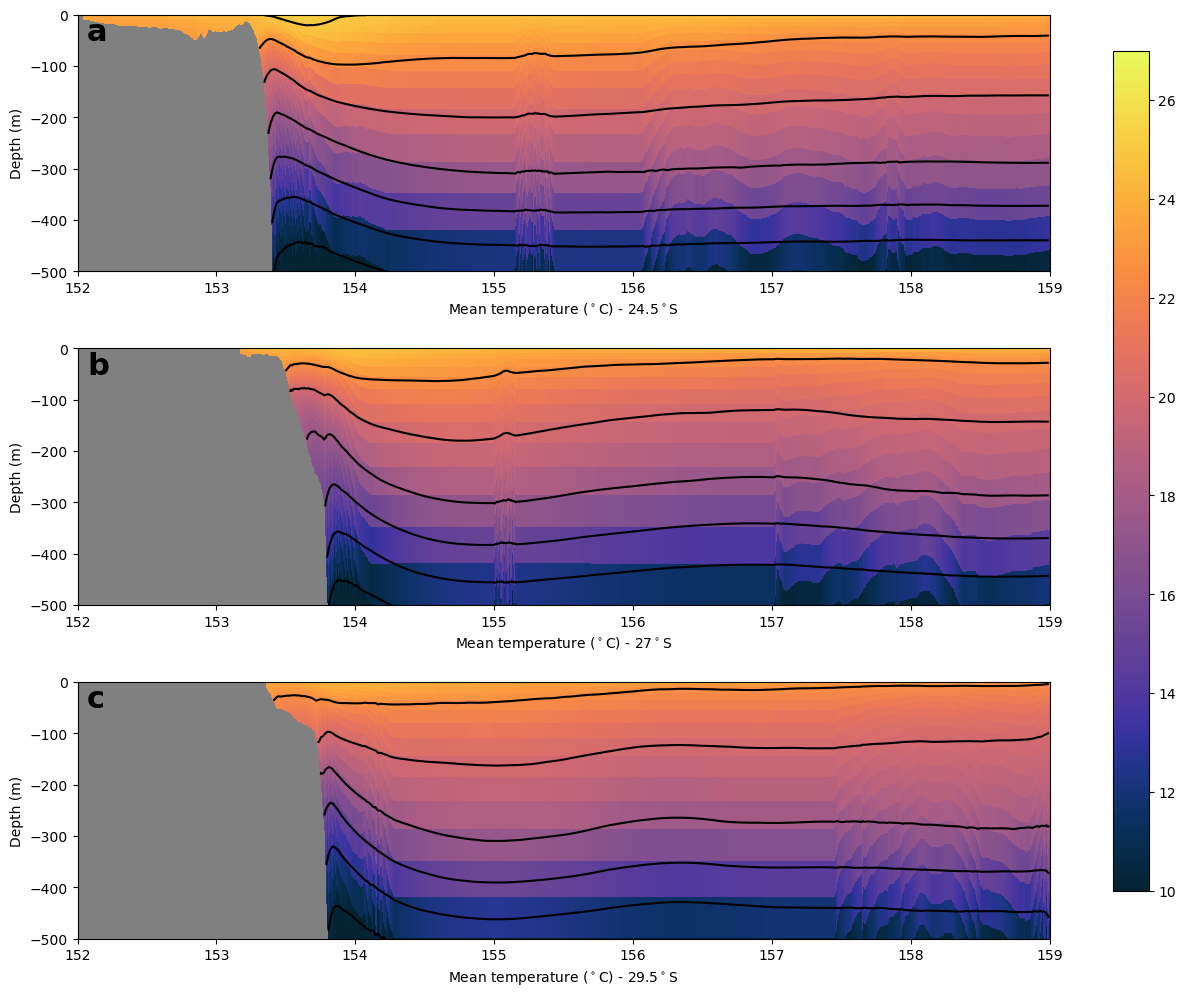

In [21]:
section1=ds.isel(eta_rho=550,xi_rho=slice(50,750))
section2=ds.isel(eta_rho=300,xi_rho=slice(50,750))
section3=ds.isel(eta_rho=50,xi_rho=slice(50,750))


gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,12])#what is this?
ax = None

ax = fig.add_subplot(gs[0,0])
ax.set_facecolor('gray')
im=section1.temp.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0',cmap='cmo.thermal',vmin=10,vmax=27)
xr.plot.contour(section1.temp.mean(dim="ocean_time"),levels=np.arange(10,30,2.5),x="lon_rho",y="z_rho0",colors='black')
plt.ylim(-500,0)
plt.xlabel('Mean temperature ($^\circ$C) - 24.5$^\circ$S')
plt.ylabel('Depth (m)')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
fig.delaxes(fig.axes[1])

ax = fig.add_subplot(gs[1,0])
ax.set_facecolor('gray')
im=section2.temp.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0',cmap='cmo.thermal',vmin=10,vmax=27)
xr.plot.contour(section2.temp.mean(dim="ocean_time"),levels=np.arange(10,30,2.5),x="lon_rho",y="z_rho0",colors='black')
plt.ylim(-500,0)
plt.xlabel('Mean temperature ($^\circ$C) - 27$^\circ$S')
plt.ylabel('Depth (m)')
fig.delaxes(fig.axes[2])
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,0])
ax.set_facecolor('gray')
im=section3.temp.mean(dim="ocean_time").plot(x='lon_rho',y='z_rho0',cmap='cmo.thermal',vmin=10,vmax=27)
xr.plot.contour(section3.temp.mean(dim="ocean_time"),levels=np.arange(10,30,2.5),x="lon_rho",y="z_rho0",colors='black')
plt.ylim(-500,0)
plt.xlabel('Mean temperature ($^\circ$C) - 29.5$^\circ$S')
plt.ylabel('Depth (m)')
fig.delaxes(fig.axes[3])
ax.set_title('')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.7, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
